In [28]:
#imports

import tensorflow as tf
import os
import cv2
import random
from PIL import Image
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG16
from keras.src.metrics.confusion_metrics import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout,Activation
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [29]:
data_dir = '/content/drive/MyDrive/Data-Copy'
train_folder = os.path.join(data_dir, 'train')
valid_folder = os.path.join(data_dir, 'valid')
test_folder = os.path.join(data_dir, 'test')
print(os.listdir(data_dir))
Cclasses = os.listdir(test_folder)
Cclasses

['valid', 'train', 'test']


['squamous.cell.carcinoma', 'normal', 'large.cell.carcinoma', 'adenocarcinoma']

# Data control

In [ ]:

#deleting corrupted files

def filter_images(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)

            if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                try:

                    with Image.open(file_path) as img:
                        img.verify()
                except OSError:

                    print(f"Removing: {file_path}")
                    os.remove(file_path)
            else:

                print(f"Removing: {file_path} - Unsupported file type")
                os.remove(file_path)

filter_images(test_folder)
filter_images(train_folder)
filter_images(valid_folder)


In [ ]:

#  oversample a class
def oversample_class(class_folder, target_count):
    files = os.listdir(class_folder)
    current_count = len(files)

    oversample_count = target_count - current_count
    if oversample_count > 0:
        oversampled_files = random.choices(files, k=oversample_count)
        for file in oversampled_files:
            source_path = os.path.join(class_folder, file)
            destination_path = os.path.join(class_folder, f"copy_{file}")
            shutil.copyfile(source_path, destination_path)

# undersample a class
def undersample_class(class_folder, target_count):
    files = os.listdir(class_folder)
    current_count = len(files)

    undersample_count = current_count - target_count
    if undersample_count > 0:
        undersampled_files = random.sample(files, k=undersample_count)
        for file in undersampled_files:
            file_path = os.path.join(class_folder, file)
            os.remove(file_path)

target_count = 181

for Cclass in os.listdir(train_folder):
    class_folder_train = os.path.join(train_folder, Cclass)

    # oversampling
    oversample_condition = len(os.listdir(class_folder_train)) < target_count
    if oversample_condition:
        oversample_class(class_folder_train, target_count)

    # undersampling
    undersample_condition = len(os.listdir(class_folder_train)) > target_count
    if undersample_condition:
        undersample_class(class_folder_train, target_count)


In [ ]:



# Function to count the number of files in a folder
def count_files(folder_path):
    try:
        with os.scandir(folder_path) as entries:
            return sum(1 for entry in entries if entry.is_file() and not entry.name.startswith('.'))
    except OSError as e:
        print(f"Error counting files in {folder_path}: {e}")
        return 0

# Function to calculate the percentage of files in a folder
def calculate_percentage(folder_path, total_files):
    folder_files = count_files(folder_path)
    return (folder_files / total_files) * 100 if total_files > 0 else 0

# Iterate through test, train, and valid folders
for folder in [test_folder, train_folder, valid_folder]:
    total_files = sum([count_files(os.path.join(folder, class_name)) for class_name in Cclasses])

    print(f"Folder: {folder}")
    for class_name in Cclasses:
        class_folder = os.path.join(folder, class_name)
        class_count = count_files(class_folder)
        class_percentage = calculate_percentage(class_folder, total_files)
        print(f"  Class: {class_name} - Count: {class_count} - Percentage: {class_percentage:.2f}%")

    print(f"  Total Files: {total_files}")
    print()



Folder: /content/drive/MyDrive/Data-Copy/test
  Class: adenocarcinoma - Count: 110 - Percentage: 36.07%
  Class: large.cell.carcinoma - Count: 51 - Percentage: 16.72%
  Class: normal - Count: 54 - Percentage: 17.70%
  Class: squamous.cell.carcinoma - Count: 90 - Percentage: 29.51%
  Total Files: 305

Error counting files in /content/drive/MyDrive/Data-Copy/train/adenocarcinoma: [Errno 2] No such file or directory: '/content/drive/MyDrive/Data-Copy/train/adenocarcinoma'
Error counting files in /content/drive/MyDrive/Data-Copy/train/large.cell.carcinoma: [Errno 2] No such file or directory: '/content/drive/MyDrive/Data-Copy/train/large.cell.carcinoma'
Error counting files in /content/drive/MyDrive/Data-Copy/train/squamous.cell.carcinoma: [Errno 2] No such file or directory: '/content/drive/MyDrive/Data-Copy/train/squamous.cell.carcinoma'
Folder: /content/drive/MyDrive/Data-Copy/train
Error counting files in /content/drive/MyDrive/Data-Copy/train/adenocarcinoma: [Errno 2] No such file or 

# Model

In [ ]:

#buiding generators
basic_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)
train_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    dtype = 'float32'
)
#data gen
train_data = train_gen.flow_from_directory(
    train_folder,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

valid_data = basic_gen.flow_from_directory(
    valid_folder,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

test_data = basic_gen.flow_from_directory(
    test_folder,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = True
)



Found 702 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 305 images belonging to 4 classes.


In [ ]:
#building model

input_shape=(224,224,3)

base_model = VGG16(
    include_top = False,
    weights="imagenet",
    input_shape = input_shape
)

#freezing layers to use the model as feature extractor
for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(4,activation = 'softmax'))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 512)         2048      
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 512)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              4719616   
                                                                 
 dropout_2 (Dropout)         (None, 1024)             

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    reduce_lr
]
results = model.fit(train_data, validation_data=valid_data, epochs=10, verbose=1)


Epoch 1/10
44/44 [==============================] - 16s 352ms/step - loss: 0.7691 - accuracy: 0.6895 - val_loss: 0.9042 - val_accuracy: 0.5278
Epoch 2/10
44/44 [==============================] - 15s 349ms/step - loss: 0.7922 - accuracy: 0.6197 - val_loss: 1.2546 - val_accuracy: 0.4583
Epoch 3/10
44/44 [==============================] - 15s 346ms/step - loss: 0.7859 - accuracy: 0.6595 - val_loss: 0.9808 - val_accuracy: 0.5278
Epoch 4/10
44/44 [==============================] - 15s 340ms/step - loss: 0.7119 - accuracy: 0.6852 - val_loss: 1.0584 - val_accuracy: 0.5000
Epoch 5/10
44/44 [==============================] - 15s 342ms/step - loss: 0.7820 - accuracy: 0.6809 - val_loss: 0.9489 - val_accuracy: 0.5972
Epoch 6/10
44/44 [==============================] - 15s 339ms/step - loss: 0.6811 - accuracy: 0.7066 - val_loss: 0.9293 - val_accuracy: 0.6944
Epoch 7/10
44/44 [==============================] - 15s 342ms/step - loss: 0.7086 - accuracy: 0.6937 - val_loss: 0.9320 - val_accuracy: 0.6111

In [ ]:
model.save('/content/drive/MyDrive/ModelData')

In [ ]:

Tumour_detect = load_model('/content/drive/MyDrive/ModelData')


OSError: No file or directory found at /content/drive/MyDrive/ModelData

In [ ]:
loss, acc = Tumour_detect.evaluate(test_data,verbose = 1)

20/20 [==============================] - 4s 170ms/step - loss: 0.8436 - accuracy: 0.6230


# Evaluation

In [ ]:
#imports
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import seaborn as sns
import numpy as np
import cv2


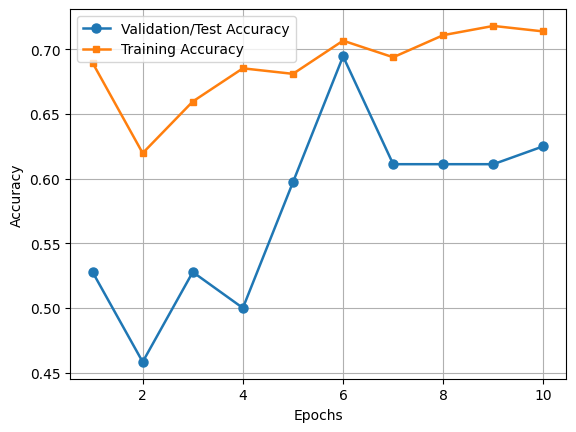

In [ ]:
res = results.history
train_acc = res['accuracy']
val_accuracy = res['val_accuracy']
epochs = range(1, len(train_acc) + 1)

line1 = plt.plot(epochs, val_accuracy, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, train_acc, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
!pip install tensorflow

Saving testImage.png to testImage (2).png
1/1 [==============================] - 0s 163ms/step


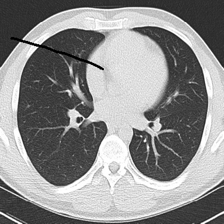

Predicted: normal
No specific treatments are recommended. Regular health check-ups are advised.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load model
Tumour_detect = tf.keras.models.load_model('/content/drive/MyDrive/ModelData')  # change this to the model data path

class_labels = {0: 'adenocarcinoma', 1: 'large.cell.carcinoma', 2: 'normal', 3: 'squamous.cell.carcinoma'}

treatments_dict = {
    0: "Adenocarcinoma is often treated with a combination of surgery, chemotherapy, and targeted therapy.",
    1: "Large cell carcinoma treatment may involve surgery, chemotherapy, and radiation therapy.",
    3: "Squamous cell carcinoma treatment may include surgery, radiation therapy, and immunotherapy.",
}

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

def predict(image_path, model):
    img_array = Image.open(image_path).convert("RGB")
    img_array = img_array.resize((224, 224))
    img_array = np.array(img_array)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model's expected input shape
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    return predicted_class

# Colab widget for file uploading
from google.colab import files

uploaded_file = files.upload()

if len(uploaded_file) > 0:
    # Get the first uploaded file
    file_path = list(uploaded_file.keys())[0]

    predicted_class = predict(file_path, Tumour_detect)

    # Display the results
    img = Image.open(file_path).convert("RGB")
    img = img.resize((224, 224))
    display(img)

    print(f"Predicted: {class_labels[predicted_class]}")

    if predicted_class != 2:  # normal class doesn't need treatment
        recommended_treatments = treatments_dict.get(predicted_class, "No specific treatments available.")
        print("Recommended Treatments:")
        print(recommended_treatments)
    else:
        print("No specific treatments are recommended. Regular health check-ups are advised.")
